In [11]:
from bs4 import BeautifulSoup
import requests
from urllib.parse import urlparse, quote
import urllib.request
import os
import pypdf
from collections import deque
import io
import re
from html.parser import HTMLParser
import pandas as pd
from dotenv import load_dotenv
load_dotenv()
import uuid
import chromadb
import ast
from langchain import HuggingFaceHub, LLMChain
from langchain.prompts import PromptTemplate
from sentence_transformers import SentenceTransformer
from langchain.chat_models import ChatOpenAI
from langchain.chains.question_answering import load_qa_chain

To crawl the webpage, I made use of the code mentioned in the OpenAI cookbook: https://github.com/openai/openai-cookbook/blob/main/apps/web-crawl-q-and-a/web-qa.ipynb?ref=mlq.ai

In [7]:


# Regex pattern 
HTTP_URL_PATTERN = r'^http[s]*://.+'

# Define domain
domain = "ashoka.edu.in"
full_url = "https://ashoka.edu.in/"

# Create the class to parse the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        self.hyperlinks = []

    # Overriding the existing functions
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])


def get_hyperlinks(url):

    try:
        with urllib.request.urlopen(url) as response:
            if not response.info().get('Content-Type').startswith("text/html"):
                return []
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))

def pdf_to_text(pdf_content):
    # Create a PDF file object from the PDF content
    pdf_file = io.BytesIO(pdf_content)

    # Create a PDF reader object
    pdf_reader = pypdf.PdfReader(pdf_file)

    # Extract text from each page of the PDF
    text = ""
    i = 0 
    print(len(pdf_reader.pages))

    for page in range(len(pdf_reader.pages)):
        text += pdf_reader.pages[i].extract_text()
        i=i+1

    return text

def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists("text/"):
        os.mkdir("text/")

    if not os.path.exists("text/" + local_domain + "/"):
        os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
        os.mkdir("processed")

    # Define the header tags to ignore while extracting text
    header_tags = ['h1', 'h2', 'h3', 'h4', 'h5', 'h6']

    # While the queue is not empty, continue crawling
    while queue:
        # Get the next URL from the queue
        url = queue.pop()
        print(url)  # for debugging and to see the progress

        response = requests.get(url)

        # Sanitize the URL to create a valid filename
        sanitized_url = quote(url, safe='')

        # Save text from the URL to a <url>.txt file
        with open('text/' + local_domain + '/' + sanitized_url + ".txt", "w", encoding="utf-8") as f:
            # Get the text from the URL using BeautifulSoup
            if response.headers.get('Content-Type') == ("application/pdf"):
                pdf_text = pdf_to_text(response.content)
                f.write(pdf_text)
            else:
                soup = BeautifulSoup(requests.get(url).text, "html.parser")

                # Remove header tags and anchor tags with titles from the soup object
                for tag in soup.find_all(header_tags):
                    tag.extract()
                for tag in soup.find_all('a', {'title': True}):
                    tag.extract()

                # Remove the text content within anchor tags but keep the anchor tags
                for tag in soup.find_all('a'):
                    tag.string = ''  # Set the text content within anchor tags to an empty string

                # Get the text from the soup object but preserve the text within span tags
                text = ""
                for tag in soup.find_all(string=True):
                    if tag.parent.name != 'span':
                        text += tag



                # Get the text but remove the remaining tags
                text = soup.get_text()

                # If the crawler gets to a page that requires JavaScript, it will stop the crawl
                if "You need to enable JavaScript to run this app." in text:
                    print("Unable to parse page " + url + " due to JavaScript being required")

                # Otherwise, write the text to the file in the text directory
                f.write(text)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)

crawl(full_url)



https://ashoka.edu.in/
https://ashoka.edu.in/roles/leadership-team/?filterby=320
https://ashoka.edu.in/javascript:;
HTTP Error 404: Not Found
https://ashoka.edu.in/roles/founders/?filterby=2198
https://ashoka.edu.in/events
https://ashoka.edu.in/roles/founders/?filterby=2200
https://ashoka.edu.in/placements
https://ashoka.edu.in/placement-internships
https://ashoka.edu.in/campus-life
https://ashoka.edu.in/campus-student-life
https://ashoka.edu.in/student-affairs
https://ashoka.edu.in/sports-exercise
https://ashoka.edu.in/campus-facilities
https://ashoka.edu.in/campus-residence-life
https://ashoka.edu.in/clubs-and-societies
https://ashoka.edu.in/../tag/clubsocity
HTTP Error 400: Bad Request
https://ashoka.edu.in/roles/leadership-team/?filterby=2180
https://ashoka.edu.in/roles/leadership-team/?filterby=319
https://ashoka.edu.in/roles/founders/?filterby=2195
https://ashoka.edu.in/ashoka-for-parents
https://ashoka.edu.in/faqs-parents
https://ashoka.edu.in/academic-calendar
https://ashoka.ed

In [3]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [4]:
texts = []

for file in os.listdir("text/ashoka.edu.in/"):
    with open("text/ashoka.edu.in/" + file, "r" , encoding="utf-8") as f:
        text = f.read()
        texts.append(text)

df = pd.DataFrame(texts, columns = ['text'])
df['text'] = remove_newlines(df.text)
df.to_csv('processed/scraped.csv', escapechar="\\")
df.head()



C:\Users\NITRO\AppData\Local\Temp\ipykernel_17480\2931785837.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')


,text
0,Chemistry Handbook GUIDELINES FOR STUDENTS ...
1,1 POLITICAL SCIENCE HANDBOOK GUIDELINES F...
2,Chemistry Handbook GUIDELINES FOR STUDENTS ...
3,Department of BIOLOGICAL SCIENCESDepartment of...
4,Students’ Guide Department of Computer Science...


<Axes: >

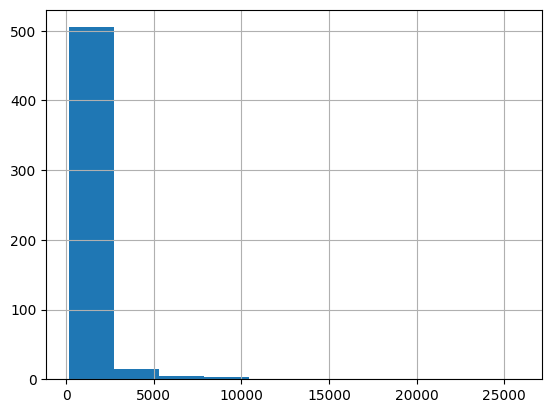

In [5]:
import tiktoken

tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv("processed/scraped.csv", index_col= 0)
df.columns = ['text']

df = df[pd.notna(df['text'])]
df['no_tokens'] = df.text.apply(lambda x : len(tokenizer.encode(x)))
df['no_tokens'].hist()

In [6]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['no_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

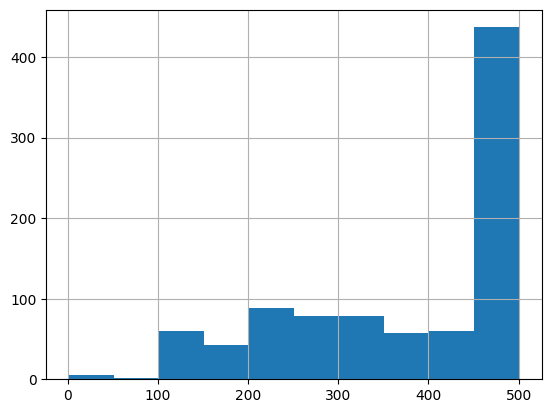

In [7]:
df = pd.DataFrame(shortened, columns=['text'])
df['no_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df["no_tokens"].hist()
df.to_csv("processed/scraped2.csv")

In [8]:
from sentence_transformers import SentenceTransformer
sentences = df['text'].to_list()

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(sentences, show_progress_bar=True)

embeddings_list = []
for embedding in embeddings:
    embeddings_list.append(embedding.tolist())
    
df['Embedding'] = embeddings_list
df.to_csv('embeddings/sentences_and_embeddings.csv')


Batches: 100%|██████████| 29/29 [00:46<00:00,  1.62s/it]


In [2]:
data = pd.read_csv("embeddings/sentences_and_embeddings.csv" ,index_col=0)
data['id'] = [str(uuid.uuid4()) for _ in range(len(data))]
data['Embedding'] = data['Embedding'].apply(lambda x: ast.literal_eval(x))


In [3]:
chroma_client = chromadb.Client()
collection = chroma_client.get_or_create_collection(name = "7th")
collection.add(

    documents=data['text'].tolist(),
    embeddings=data['Embedding'].tolist(), 
    ids = data['id'].tolist()
)

In [4]:
def matching_docs(question, n_results = 1, include=['documents']):
    context = collection.query(
        query_texts= [question],
        n_results=n_results,
        include=include

    )
    return {"page_content" :context['documents']}
query = " what is a cs major?"
answer = matching_docs(query)
print(answer)


{'page_content': [['The course divisions and credit points requirement within three years for a Major in Computer Science are as follow: •Foundation and Critical Thinking courses •Co-Curricular courses (4 credits) •Computer Science Major courses –The course division for Computer Science Major courses is given below: 1.Compulsory 10 core courses for 40 credits. 2.A minimum of 20 credits of electives offered by the CS department. •Other Courses 2.1.1 CS Core Courses These are the courses you have to take in order to obtain a BSc. (Hons) degree in CS from Ashoka. Please note that the references books mentioned aren’t ofﬁcial recommendations. 1.Discrete Math 2.Probability and Statistics 3.Introduction to Computer Program- ming 4.Computer Organization and Systems 5.Advanced Programming6.Operating Systems 7.Algorithm Design and Analysis 8.Computer Networks 9.Introduction to Machine Learning 10.Programming language Design and Im- plementation8 Chapter 2. Curriculum 2.1.2 CS Elective Courses H

In [12]:
template = """ Answer the question based on the context that is given. If the answer can not be answered with the given context/information, reply "i do not know"

Context:{context}

Question:{query}

Answer:
"""

chat_prompt = prompt_template = PromptTemplate(
    input_variables=['query', 'context'],
    template=template

)


In [19]:
hub_llm = HuggingFaceHub(repo_id='gpt2')
question = "what are the requirements to become a cs major?"
results = matching_docs(query)
llm_chain = LLMChain(llm=hub_llm, prompt= chat_prompt, verbose=True)
print(llm_chain.run(query = question, context = results))



> Entering new LLMChain chain...
Prompt after formatting:
 Answer the question based on the context that is given. If the answer can not be answered with the given context/information, reply "i do not know"

Context:{'page_content': [['Of these 36 cred- its, a minimum of 28 credits must come from ”Mathematics core course list for CS+Math interdisciplinary Major”. The core list is given below. •The remaining 4 credits can come from any Computer Science/Mathematics courses. •Computer Science Introduction to Computer Programming Computer Organization and Systems Algorithm Design and Analysis Computer Networks Introduction to Machine Learning Computer Security and Privacy Theory of Computation•Mathematics Calculus Linear Algebra Algebra I Probability Real Analysis Multivariable Calculus Statistics 2.4.2 CS and Entrepreneurship For this interdisciplinary Major, students, in addition to 4 courses (16 credits) in the Entrepreneurship department, must complete all Computer Science pure Major

In [20]:
prompt = PromptTemplate(
    input_variables=['question'],
    template="Transalate English to sql : {question}"
)

hub_chain = LLMChain(llm=hub_llm, prompt=prompt, verbose=True)
print(hub_chain.run("To find the meadian age of repsondents from a database?"))



> Entering new LLMChain chain...
Prompt after formatting:
Transalate English to sql : To find the meadian age of repsondents from a database?

> Finished chain.


